# **Vähimruutude meetod** kindlustusjuhtumite näitel

Analüüsime seost nõuete arvu ja kogumakse vahel.

andmestik sisaldab järgmist:

X = nõuete arv piirkonnas

Y = kõigi nõuete kogumakse tuhandetes eurodes vastavas piirkonnas


In [53]:
from IPython.display import display, Math
import os
import sys
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from sklearn.model_selection import train_test_split

In [31]:
# Failide uploadimine
from google.colab import files
uploaded = files.upload()

Saving kindlustusjuhtumid.xls to kindlustusjuhtumid (1).xls


In [43]:
import os
# Loetleb kõik failid ja kaustad /content kataloogis
print(os.listdir('/content'))

['.config', 'kindlustusjuhtumid.xls', 'sample_data']


In [42]:
import os

# Faili kustutamine
os.remove('kindlustusjuhtumid (1).xls')

# Exceli faili lugemine Pandas'e abil

In [45]:
df = pd.read_excel('kindlustusjuhtumid.xls', engine='xlrd')
df.head()

*** No CODEPAGE record, no encoding_override: will use 'iso-8859-1'


,X,Y
0,108,392.5
1,19,46.2
2,13,15.7
3,124,422.2
4,40,119.4


# Jaotuste visualiseerimine

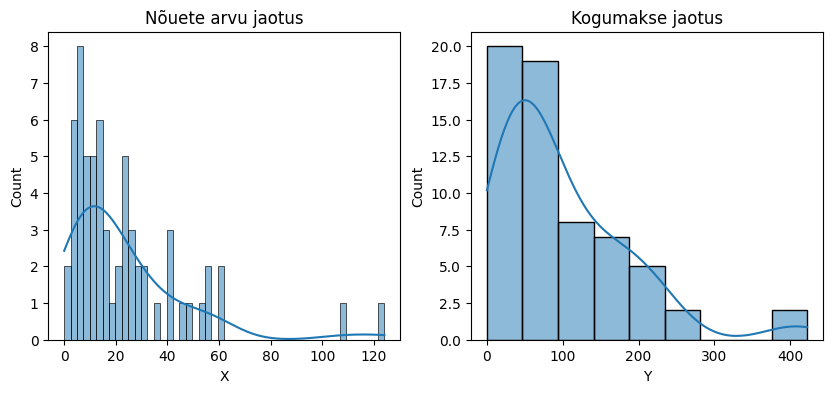

In [46]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.set_title('Nõuete arvu jaotus')
ax2.set_title('Kogumakse jaotus')

sns.histplot(df.X, bins=50, kde=True, ax=ax1)
sns.histplot(df.Y, kde=True, ax=ax2)

plt.show()


# Korrelatsioon:

Nõuete arv ja kogumakse on väga tugevalt korreleeritud

<Axes: >

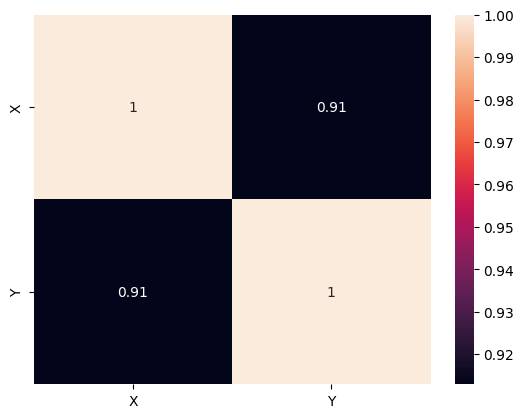

In [47]:
sns.heatmap(df.corr(), annot=True)

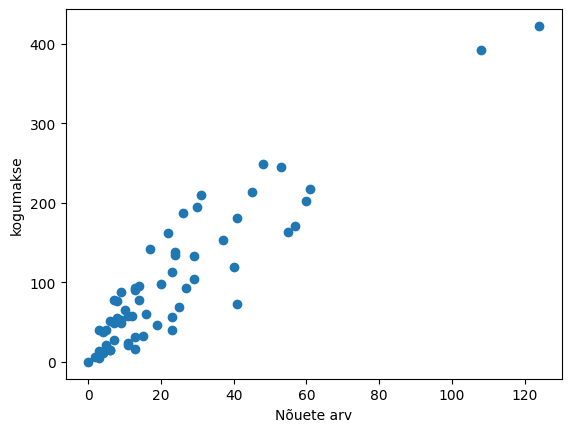

In [48]:
plt.xlabel('Nõuete arv')
plt.ylabel('kogumakse')
plt.scatter(df['X'], df['Y'])

# Andmete treenimine Vähimruutude meetodiga
Muudan andmed PyTorch vormingusse ja eraldan andmed treeninguks ja testimiseks.

In [49]:
data = df.to_numpy()
X = torch.from_numpy(data[:, 0]).float().unsqueeze(1)
y = torch.from_numpy(data[:, 1]).float().unsqueeze(1)
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.25, random_state=50)

Vähimruutude meetod:

$\large y = b_0 + b_1 x$

$\large b_1 = \frac{\text{Cov}(x, y)}{Var(x)} = \frac{\sum_i{(x_i - \mathbb{E}[x]) * (y_i - \mathbb{E}[y])}}{\sum_i{(x_i - \mathbb{E}[x])^2}} $

In [50]:
def linear_regression_1d(X, y):
    """Trains a linear regression on 1D data

    Args:
        X: A numpy array for the training samples
        y: A numpy array for the labels of each sample
    """
    X_m = X.mean(dim=0)
    y_m = y.mean(dim=0)

    X_c = (X - X_m)

    # Compute covariance and variance
    covar = (X_c * (y - y_m)).sum(dim=0)
    var = X_c.pow(2).sum(dim=0)

    # Divide covariance by variance
    b_1 = covar / var

    # Get bias
    b_0 = y_m - b_1 * X_m.sum(dim=0)
    return b_0, b_1

# Regressioni sirge

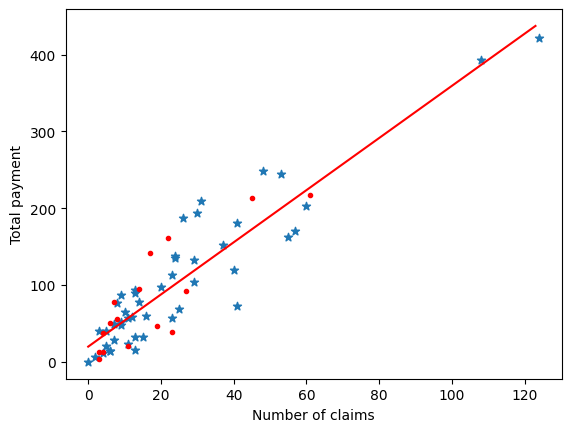

In [51]:
b_0, b_1 = linear_regression_1d(X_train, Y_train)
plt.scatter(X_train, Y_train, marker='*')
plt.scatter(X_test, Y_test, marker='.', color='red')

x = [int(elt) for elt in range(0, int(X.cpu().numpy().max()))]
y = b_0.numpy() + b_1.numpy() * x
plt.plot(x, y, color='red')

ax = plt.gca()
ax.set_xlabel('Number of claims')
ax.set_ylabel('Total payment')
plt.show()

#  Mean Square Error (MSE)  - Ruutkeskmine hälve

In [52]:
pred_train = b_0 + b_1 * X_train
err_train = Y_train - pred_train
mse_train = err_train.T.mm(err_train) / Y_train.shape[0]

pred_test = b_0 + b_1 * X_test
err_test = Y_test - pred_test
mse_test = err_test.T.mm(err_test) / Y_test.shape[0]

print('Train MSE:\t', mse_train.item())
print('Test MSE:\t', mse_test.item())

Train MSE:	 1241.571533203125
Test MSE:	 1279.6763916015625


Treening- ja test mse-d on üksteisele lähedased. Mudel ei ole ei ülefititud ega alafititud

Kuna nõuete arv ja maksete kogusumma on tugevas korrelatsioonis, siis lineaarne regressioon töötab üsna hästi.